# Imports

In [1]:
! pip install transformers
! pip install datasets

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
import pandas as pd
from datasets import Dataset
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,
                          DataCollatorWithPadding,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)

# Helper Functions

In [3]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-12 21:38:13--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-12 21:38:13 (61.2 MB/s) - ‘helper_functions.py.1’ saved [7752/7752]



In [4]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

# Data Preparation

In [6]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d arashnic/mind-news-dataset
! unzip "/content/mind-news-dataset.zip" -d "/content/dataset/"

 92% 57.0M/61.7M [00:00<00:00, 57.2MB/s]
100% 61.7M/61.7M [00:00<00:00, 65.4MB/s]
Archive:  /content/mind-news-dataset.zip
  inflating: /content/dataset/MINDsmall_train/behaviors.tsv  
  inflating: /content/dataset/MINDsmall_train/entity_embedding.vec  
  inflating: /content/dataset/MINDsmall_train/news.tsv  
  inflating: /content/dataset/MINDsmall_train/relation_embedding.vec  
  inflating: /content/dataset/news.tsv/news.tsv  


In [5]:
df = pd.read_csv("/content/dataset/news.tsv/news.tsv", header=None, sep='\t')
df.columns=['News ID', "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"]
dataset = Dataset.from_pandas(df)

In [6]:
dataset

Dataset({
    features: ['News ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entities'],
    num_rows: 51282
})

In [7]:
dataset[0]

{'News ID': 'N55528',
 'Category': 'lifestyle',
 'SubCategory': 'lifestyleroyals',
 'Title': 'The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By',
 'Abstract': "Shop the notebooks, jackets, and more that the royals can't live without.",
 'URL': 'https://assets.msn.com/labs/mind/AAGH0ET.html',
 'Title Entities': '[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]',
 'Abstract Entities': '[]'}

In [8]:
classes = list(set(dataset['SubCategory']))
classes_dict = {classes[i]: i for i in range(len(classes))}
reverse_dict_classes = {i:classes[i] for i in range(len(classes))}
num_classes = len(classes_dict)
print("Number of subcategorys:", num_classes)
print("subcategorys:", classes_dict)

Number of subcategorys: 264
subcategorys: {'healthyliving': 0, 'tvvideos': 1, 'cooking': 2, 'holidays': 3, 'photos': 4, 'reviews': 5, 'movienews': 6, 'movies-celebrity': 7, 'basketball_wnba': 8, 'icehockey_nhl': 9, 'gaming': 10, 'autosnews': 11, 'finance-insidetheticker': 12, 'autosresearchguides': 13, 'tennis_intl': 14, 'football_ncaa': 15, 'causes-environment': 16, 'autossema': 17, 'video': 18, 'healthagingwell': 19, 'personalfinance': 20, 'financenews': 21, 'finance-education': 22, 'lifestylediy': 23, 'cardio': 24, 'finance-credit': 25, 'tv-reviews': 26, 'lifestylehoroscopefish': 27, 'beverages': 28, 'football_nfl_videos': 29, 'football_ncaa_videos': 30, 'causes-military-appreciation': 31, 'foodrecipes': 32, 'middleeast-top-stories': 33, 'olympics-videos': 34, 'traveltripideas': 35, 'lifestylestyle': 36, 'lifestyleshoppinghomegarden': 37, 'shop-home-goods': 38, 'autosreview': 39, 'topnews': 40, 'finance-healthcare': 41, 'basketball_ncaa_videos': 42, 'autosenthusiasts': 43, 'newsvide

In [9]:
def preprocess(dataset):
  return {'title': dataset['Title'], 'category': classes_dict[dataset['SubCategory']]}

In [10]:
dataset = dataset.map(preprocess)

Map:   0%|          | 0/51282 [00:00<?, ? examples/s]

In [11]:
dataset[0]

{'News ID': 'N55528',
 'Category': 'lifestyle',
 'SubCategory': 'lifestyleroyals',
 'Title': 'The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By',
 'Abstract': "Shop the notebooks, jackets, and more that the royals can't live without.",
 'URL': 'https://assets.msn.com/labs/mind/AAGH0ET.html',
 'Title Entities': '[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]',
 'Abstract Entities': '[]',
 'title': 'The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By',
 'category': 69}

In [12]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

In [13]:
def preprocess_function(examples):
  return tokenizer(examples["Title"], padding=True, truncation=True, max_length=30)

In [14]:
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/51282 [00:00<?, ? examples/s]

In [15]:
dataset

Dataset({
    features: ['News ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title Entities', 'Abstract Entities', 'title', 'category', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 51282
})

In [16]:
BATCH_SIZE=8

In [17]:
tf_dataset = dataset.to_tf_dataset(columns=['input_ids', 'token_type_ids', 'attention_mask', 'category'],
                                  shuffle = True,
                                  batch_size = BATCH_SIZE)

In [18]:
def swap_positions(dataset):
  return {'input_ids': dataset['input_ids'],
          'token_type_ids': dataset['token_type_ids'],
          'attention_mask': dataset['attention_mask'],}, dataset['category']

In [19]:
tf_dataset = tf_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [20]:
train_dataset = tf_dataset.take(int(0.8*len(tf_dataset)))
val_dataset = tf_dataset.skip(int(0.8*len(tf_dataset)))

In [21]:
train_dataset

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, 30), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 30), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 30), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
for batch_example in train_dataset.take(1):
  pass
  #print(batch_example[0])

# Model

In [23]:
model = TFBertForSequenceClassification.from_pretrained(model_id, num_labels=264)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  203016    
                                                                 
Total params: 109685256 (418.42 MB)
Trainable params: 109685256 (418.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
input_ids = Input(shape =(30,), dtype=tf.int64, name='input_ids')
token_type_ids = Input(shape =(30,), dtype=tf.int64,name='token_type_ids')
attention_mask = Input(shape =(30,), dtype=tf.int64,name='attention_mask')

x = model([input_ids, token_type_ids, attention_mask])
logits = x.logits
x = Dense(512, activation='relu')(logits)
output = Dense(264, activation='softmax', name='category')(x)

custom_bert = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs = output)
custom_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                              

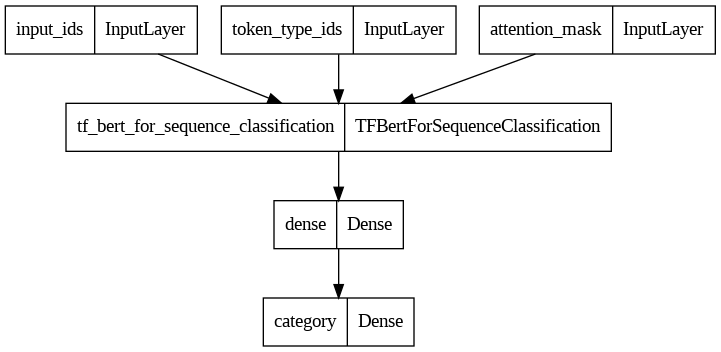

In [25]:
plot_model(custom_bert)

In [26]:
BATCH_SIZE = 8
num_epochs = 5
batches_per_epoch = len(dataset) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [27]:
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [28]:
def top_k_accuracy(y_true, y_pred, k=5):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=k)

In [29]:
custom_bert.compile(loss = SparseCategoricalCrossentropy(),
                    optimizer = optimizer,
                    metrics = ['accuracy'])

In [30]:
history = custom_bert.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=num_epochs)

Epoch 1/5
5128/5128 [==============================] - 640s 113ms/step - loss: 2.3905 - accuracy: 0.4505 - val_loss: 1.6274 - val_accuracy: 0.5865
Epoch 2/5
5128/5128 [==============================] - 573s 112ms/step - loss: 1.6188 - accuracy: 0.5850 - val_loss: 1.3312 - val_accuracy: 0.6569
Epoch 3/5
5128/5128 [==============================] - 557s 109ms/step - loss: 1.2980 - accuracy: 0.6589 - val_loss: 1.0130 - val_accuracy: 0.7327
Epoch 4/5
5128/5128 [==============================] - 559s 109ms/step - loss: 1.0527 - accuracy: 0.7191 - val_loss: 0.8147 - val_accuracy: 0.7835
Epoch 5/5
5128/5128 [==============================] - 551s 107ms/step - loss: 0.8620 - accuracy: 0.7731 - val_loss: 0.6016 - val_accuracy: 0.8469


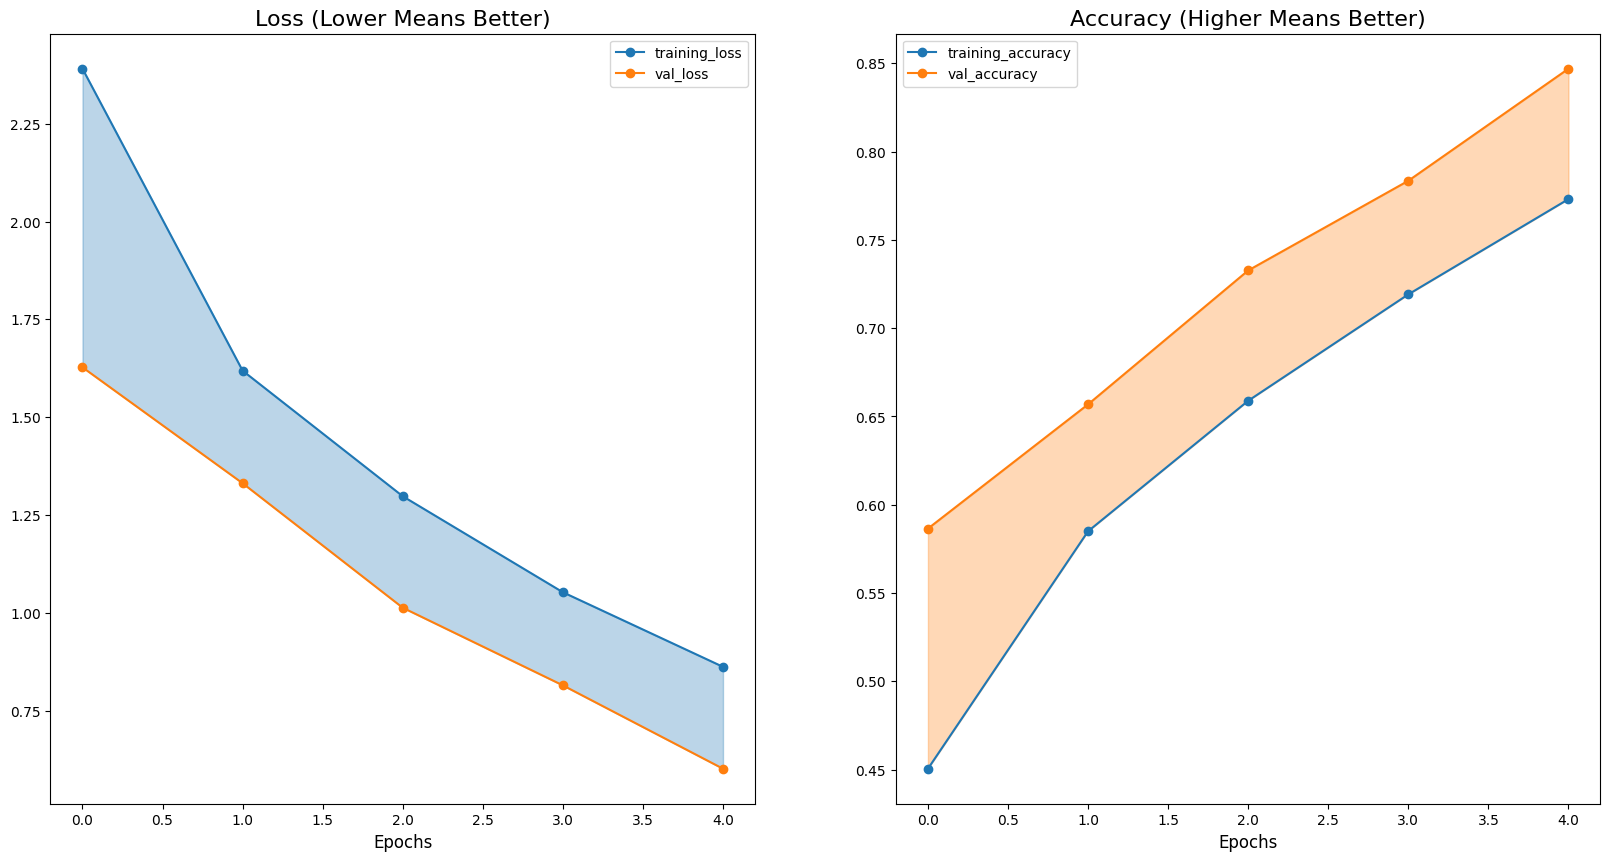

In [31]:
plot_loss_curves(history)

# Model Evaluation

In [32]:
import numpy as np

In [33]:
true_labels = []
predicted_labels = []
text = []

for batch_news, batch_labels in val_dataset:
    batch_predictions = custom_bert.predict(batch_news)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    text.extend(batch_news)
    true_labels.extend(batch_labels)
    predicted_labels.extend(batch_predicted_labels)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 48ms/step


In [34]:
model_results = calculate_results(y_true = true_labels,
                                  y_pred = predicted_labels)
model_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 84.07096899980503,
 'precision': 0.8196354078495773,
 'recall': 0.8407096899980503,
 'f1': 0.82119097268188}

In [35]:
print("Classification Report")
print(classification_report(true_labels, predicted_labels))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           6       0.88      0.96      0.92        47
           7       0.69      0.82      0.75        40
           8       0.00      0.00      0.00         2
           9       0.99      1.00      1.00       101
          10       0.89      0.89      0.89        19
          11       0.80      0.84      0.82       177
          13       0.00      0.00      0.00         4
          15       0.88      0.98      0.93       314
          17       0.00      0.00      0.00         6
          18       1.00      0.05      0.10        20
          20       0.56      0.92      0.70        26
          21       0.71      0.55      0.62       135
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00         1
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Saving Model

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
custom_bert.save("News_Subcategory_Classification")

In [39]:
from tensorflow.keras.models import load_model

In [40]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

def custom_objects():
    return {"TFBertForSequenceClassification": TFBertForSequenceClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/News_Subcategory_Classification")

In [38]:
! cp -av /content/News_Subcategory_Classification /content/drive/MyDrive/News_Subcategory_Classification

'/content/News_Subcategory_Classification' -> '/content/drive/MyDrive/News_Subcategory_Classification'
'/content/News_Subcategory_Classification/variables' -> '/content/drive/MyDrive/News_Subcategory_Classification/variables'
'/content/News_Subcategory_Classification/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/News_Subcategory_Classification/variables/variables.data-00000-of-00001'
'/content/News_Subcategory_Classification/variables/variables.index' -> '/content/drive/MyDrive/News_Subcategory_Classification/variables/variables.index'
'/content/News_Subcategory_Classification/assets' -> '/content/drive/MyDrive/News_Subcategory_Classification/assets'
'/content/News_Subcategory_Classification/fingerprint.pb' -> '/content/drive/MyDrive/News_Subcategory_Classification/fingerprint.pb'
'/content/News_Subcategory_Classification/saved_model.pb' -> '/content/drive/MyDrive/News_Subcategory_Classification/saved_model.pb'
'/content/News_Subcategory_Classification/keras_metad

# Hugging Face

In [41]:
! pip install huggingface_hub

In [42]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

def custom_objects():
    return {"TFBertForSequenceClassification": TFBertForSequenceClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/News_Subcategory_Classification")

In [43]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = loaded_model, repo_id = "DriveMyScream/News_Subcategory_Classification")

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/233k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/440M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/News_Subcategory_Classification/tree/main/'

In [53]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification
from huggingface_hub import from_pretrained_keras

def custom_objects():
    return {"TFBertForSequenceClassification": TFBertForSequenceClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = from_pretrained_keras("DriveMyScream/News_Subcategory_Classification")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [54]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

In [55]:
import tensorflow as tf

input_texts = ["After setting up my account, I feel like I need to change it. How do I go about that? I purchased a product, which I now want to change"]
inputs = tokenizer(input_texts, padding=True, truncation=True, max_length=30, return_tensors="tf")
logits = loaded_model.predict([inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']])
predicted_class_indices = tf.argmax(logits, axis=1)
predicted_classes = reverse_dict_classes[predicted_class_indices.numpy()[0]]
print(predicted_classes)

1/1 [==============================] - 4s 4s/step
personalfinance


# Tensorflow Lite


In [45]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

def custom_objects():
    return {"TFBertForSequenceClassification": TFBertForSequenceClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = tf.keras.models.load_model("/content/News_Subcategory_Classification")

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "News_Subcategory_Classification.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [49]:
interpreter = tf.lite.Interpreter(model_path="News_Subcategory_Classification.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

input_texts = ["After setting up my account, I feel like I need to change it. How do I go about that? I purchased a product, which I now want to change"]
inputs = tokenizer(input_texts, padding=True, truncation=True, max_length=30, return_tensors="tf")
attention_mask = tf.cast(inputs['attention_mask'], tf.int64)
input_ids = tf.cast(inputs['input_ids'], tf.int64)
token_type_ids = tf.cast(inputs['token_type_ids'], tf.int64)

interpreter.set_tensor(input_details[0]['index'], attention_mask)
interpreter.set_tensor(input_details[1]['index'], input_ids)
interpreter.set_tensor(input_details[2]['index'], token_type_ids)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_indices = tf.argmax(output_data, axis=1)
predicted_classes = reverse_dict_classes[predicted_class_indices.numpy()[0]]
print(predicted_classes)

personalfinance
